# Machine Learning Notes: Feature Encoding II
<hr>
Author: [Diego Marinho de Oliveira](http://br.linkedin.com/in/dmztheone) [(GitHub)](http://www.github.com/dmoliveira)


## 1. Introduction

This notebook is a study to observe the potential of feature encoding. Althought there are a considerable amount of studies that claims the benefit of feature encoding, this notebook try to verify it empirically. Also, the studies don't show how to do it, and this notebook give a chance to Data Scientists and Machine Learning Practioners see some smart tricks on data. At least but not less, all the notebook was made on [Julia](http://www.julialang.org)! This is an awesome language that are conquering me every day! You can see more notebooks like this one throught my GitHub page. Every one is now coding in Julia.

In [2]:
using MLBase
using DataFrames
using RDatasets
using Lasso
using GLM
using GLMNet
using LIBSVM
using DecisionTree
using XGBoost
using NeuralNets
using Gadfly

## 2. Method Definitions

#### Encode Data Method

In [3]:
function encode_data(data, features)
    
    encoded_data = copy(data)
    encoders     = Dict([f => labelmap(data[:, f]) for f in features])
    
    for f in features
        encoded_data[:, f] = labelencode(encoders[f], encoded_data[:, f])
    end
    
    return encoded_data
end

encode_data (generic function with 1 method)

#### Train, Predict and Eval Methods

In [4]:
abstract Model
type LM <: Model end
type SVM <: Model end
type ANN <: Model end
type DecisionTrees <: Model end
type RandomForest <: Model end
type XGB <: Model end

train(::Type{LM}, X, y)            = glmnet(X, y)
train(::Type{SVM}, X, y)           = 0
train(::Type{ANN}, X, y)           = 0
train(::Type{DecisionTrees}, X, y) = build_tree(y, X)
train(::Type{RandomForest}, X, y)  = build_forest(y, X, 4, 100, 5, 0.7)
train(::Type{XGB}, X, y)           = xgboost(X, 10, label=y, eta=.3, max_depth=4, silent=1)

predict(::Type{LM}, model, X)            = (yhat=GLMNet.predict(model, X); return [mean(yhat[i,:]) for i=1:size(yhat,1)])
predict(::Type{SVM}, model, X)           = 0
predict(::Type{ANN}, model, X)           = 0
predict(::Type{DecisionTrees}, model, X) = apply_tree(model, X)
predict(::Type{RandomForest}, model, X)  = apply_forest(model, X)
predict(::Type{XGB}, model, X)           = XGBoost.predict(model, X)

rmse(Y, YHat) = sqrt(sum((Y - YHat) .^ 2)/length(Y))
accuracy(Y, YHat) = sum(Array{Int8}(Y .== YHat))/length(Y)

accuracy (generic function with 1 method)

#### Evaluate All Models

In [5]:
function analyze_models(X, y, Xval, metric, model_list)
    
    results = []
    
    for model_name in model_list
        model  = train(model_name, X, y)
        yhat   = predict(model_name, model, Xval)
        result = metric(y, yhat)
        push!(results, result)
    end
    
    dataframe = DataFrame(Model=model_list, RMSE=results)
    sort!(dataframe, cols=:RMSE)
    
    return dataframe
end

analyze_models (generic function with 1 method)

#### Binarize All Features

In [6]:
function binarize_feature!(data, feature)
    unique_values = [ symbol(feature, "=", value) for value in Set(data[:, feature]) ]
    nrows, ncols  = size(data, 1), length(unique_values)
    rows          = fill(0, nrows, ncols)
    for i=1:nrows
        rows[i, data[i, feature]] = 1
    end
    
    for j=1:ncols
        data[unique_values[j]] = rows[:, j]
    end
    
    return data
end

function binarize_features!(data, feature_list)
    
    for feature in feature_list
        binarize_feature!(data, feature)
    end
    
    return data
end

binarize_features! (generic function with 1 method)

#### Categorize Continous/Discrete Features

In [7]:
function generate_evaluation_function_list(interval_list)
    
    length(interval_list) == 0 && error("Empty list.")
    length(interval_list) == 1 && error("List need to be size >= 2.")
    
    eval_list = [x -> x <= interval_list[1]]
    
    for i=1:length(interval_list)-1
        push!(eval_list, x -> interval_list[i] < x <= interval_list[i+1])
    end
    
    push!(eval_list, x -> x > interval_list[end])
    
    return eval_list
    
end

function categorize_feature!(data, feature, evaluate_function_list)
    
    nrows, ncols = size(data, 1), length(evaluate_function_list)
    new_features = [ symbol(feature, "=", i) for i=1:ncols]
    rows         = fill(0, nrows, ncols)
    
    for i=1:nrows, j=1:ncols
        rows[i, j] = evaluate_function_list[j](data[i, feature])? 1 : 0
    end
    
    for j=1:ncols
        data[new_features[j]] = rows[:, j]
    end
    
    return data
end

categorize_feature! (generic function with 1 method)

In [9]:
RDatasets.packages()

,Package,Title
1,COUNT,"Functions, data and code for count data."
2,Ecdat,Data sets for econometrics
3,HSAUR,A Handbook of Statistical Analyses Using R (1st Edition)
4,HistData,Data sets from the history of statistics and data visualization
5,ISLR,Data for An Introduction to Statistical Learning with Applications in R
6,KMsurv,"Data sets from Klein and Moeschberger (1997), Survival Analysis"
7,MASS,Support Functions and Datasets for Venables and Ripley's MASS
8,SASmixed,"Data sets from ""SAS System for Mixed Models"""
9,Zelig,Everyone's Statistical Software
10,adehabitatLT,Analysis of Animal Movements


In [10]:
RDatasets.datasets("HSAUR")

,Package,Dataset,Title,Rows,Columns
1,HSAUR,BCG,BCG Vaccine Data,13,7
2,HSAUR,BtheB,Beat the Blues Data,100,8
3,HSAUR,CYGOB1,CYG OB1 Star Cluster Data,47,2
4,HSAUR,Forbes2000,The Forbes 2000 Ranking of the World's Biggest Companies (Year 2004),2000,8
5,HSAUR,GHQ,General Health Questionnaire,22,4
6,HSAUR,Lanza,Prevention of Gastointestinal Damages,198,3
7,HSAUR,agefat,Total Body Composision Data,25,3
8,HSAUR,aspirin,Aspirin Data,7,5
9,HSAUR,birthdeathrates,Birth and Death Rates Data,69,3
10,HSAUR,bladdercancer,Bladder Cancer Data,31,3


In [11]:
head(dataset("HSAUR", "Forbes2000"))

,Rank,Name,Country,Category,Sales,Profits,Assets,MarketValue
1,1,Citigroup,United States,Banking,94.71,17.85,1264.03,255.3
2,2,General Electric,United States,Conglomerates,134.19,15.59,626.93,328.54
3,3,American Intl Group,United States,Insurance,76.66,6.46,647.66,194.87
4,4,ExxonMobil,United States,Oil & gas operations,222.88,20.96,166.99,277.02
5,5,BP,United Kingdom,Oil & gas operations,232.57,10.27,177.57,173.54
6,6,Bank of America,United States,Banking,49.01,10.81,736.45,117.55


## 3. Analyzing Forbes2000 Dataset (I)

### 3.1. Load Data

In [12]:
data = dataset("HSAUR", "Forbes2000");

### 3.2. Define Features and Output

In [13]:
features     = [:Country, :Category, :Sales, :Profits, :Assets]
cat_features = [:Country, :Category]
output        = :MarketValue;

In [186]:
model_list = [LM, DecisionTrees, RandomForest, XGB];

### 3.3. Data Sample

In [14]:
head(data)

,Rank,Name,Country,Category,Sales,Profits,Assets,MarketValue
1,1,Citigroup,United States,Banking,94.71,17.85,1264.03,255.3
2,2,General Electric,United States,Conglomerates,134.19,15.59,626.93,328.54
3,3,American Intl Group,United States,Insurance,76.66,6.46,647.66,194.87
4,4,ExxonMobil,United States,Oil & gas operations,222.88,20.96,166.99,277.02
5,5,BP,United Kingdom,Oil & gas operations,232.57,10.27,177.57,173.54
6,6,Bank of America,United States,Banking,49.01,10.81,736.45,117.55


## <span style="color:blue">Round 1</span>

### 3.4. Data Encode: Round 1 (Shallow Encoded)

In [135]:
encoded_data = encode_data(data[:, vcat(features, output)], cat_features)
encoded_data[isnan(encoded_data[:, 4]), 4] = median(encoded_data[!isnan(encoded_data[:, 4]), 4]);

### 3.5. Train And Evaluate: Round 1

In [264]:
X, y = Array{Float64, 2}(encoded_data[:, features]), Array{Float64, 1}(encoded_data[output]);

In [265]:
analyze_models(X, y, X, rmse, model_list)

,Model,RMSE
1,DecisionTrees,4.297163057277828
2,RandomForest,6.896041041590683
3,XGB,6.993713117201217
4,LM,16.92750603781559


## <span style="color:blue">Round 2</span>

### 3.6. Data Encode: Round 2 (Categorical Binarized Encoded)

In [309]:
encoded_data2 = binarize_features!(copy(encoded_data[:, vcat(features, output)]), [:Country, :Category]);

In [314]:
new_features = setdiff(names(encoded_data2), [:Country, :Category]);

### 3.7. Train And Evaluate: Round 2

In [315]:
X, y = Array{Float64, 2}(encoded_data2[:, new_features]), Array{Float64, 1}(encoded_data2[output]);

In [316]:
analyze_models(X, y, X, rmse, model_list)

,Model,RMSE
1,DecisionTrees,0.9389780832550524
2,XGB,1.5828800058092913
3,LM,6.870691606186913
4,RandomForest,16.22804927254093


## <span style="color:blue">Round 3</span>

### 3.8. Data Encode: Round 3 (Fully Encoded)

In [333]:
# Sales
eval_list = generate_evaluation_function_list([1, 2, 5, 10, 20, 30, 60, 90, 120, 150])
encoded_data3 = categorize_feature!(copy(encoded_data2), :Sales, eval_list)

eval_list = generate_evaluation_function_list([-5, -2, 0, 2, 5])
categorize_feature!(encoded_data3, :Profits, eval_list)

eval_list = generate_evaluation_function_list([1, 25, 50])
categorize_feature!(encoded_data3, :Assets, eval_list)

new_features = setdiff(names(encoded_data3), [:Sales, :Profits, :Assets]);

X, y = Array{Float64, 2}(encoded_data3[:, new_features]), Array{Float64, 1}(encoded_data3[output])
analyze_models(X, y, X, rmse, model_list)

,Model,RMSE
1,DecisionTrees,0.9389780832550524
2,XGB,1.5828800058092913
3,LM,6.870691606186913
4,RandomForest,14.639966653736243


## Results

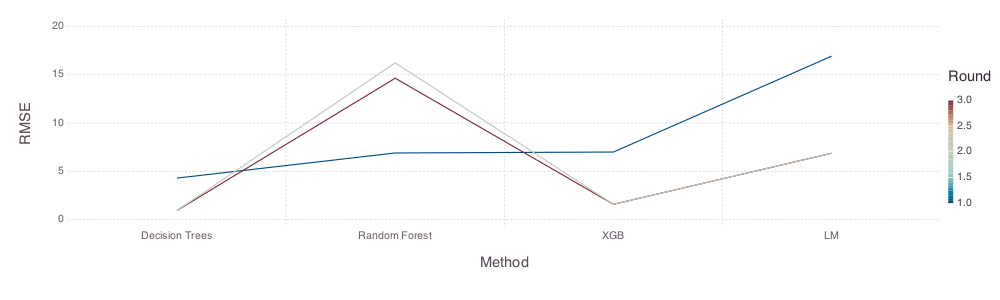

In [350]:
rounds       = [fill(1, 4); fill(2, 4); fill(3, 4)]
methods_name = vcat(fill(["Decision Trees", "Random Forest", "XGB", "LM"], 3)...)
rmses        = [4.297163057277828, 6.896041041590683, 6.993713117201217, 16.92750603781559, 
                0.9389780832550524, 16.22804927254093, 1.5828800058092913, 6.870691606186913, 
                0.9389780832550524, 14.639966653736243, 1.5828800058092913, 6.870691606186913]

results = DataFrame(Round=rounds, Method=methods_name, RMSE=rmses)
set_default_plot_size(1000px, 300px)
plot(results, x=:Method, color=:Round, y=:RMSE, Geom.line)

**Preliminar Conclusion:** Using encode produce better results. The results improves in general more than the double. For some reason Random Forest was not benefitiated by the encoders. But all other methods were. Also LM not improved much as trees based models. This indicates that the problem could not be a linear one. Also surprisly, trees that has its splits made by gini index were benefited by manual feature segmentation.